# Import and Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

In [2]:
# read data
df_music = pd.read_csv('../data/five_k.csv')

# some cleaning
df_music = df_music.replace(r"^ +| +$", r"", regex=True)
df_music = df_music.rename(columns=lambda x: x.strip())

# drop useless cols
df_music = df_music.drop(columns=['Unnamed: 0', 'duration_ms', 'type', 'html'])
df_music.head(8)

# drop duplicate rows
#df_music.duplicated().value_counts()
df_music = df_music.drop_duplicates()

In [3]:
df_music.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,5171.000000,5171.000000,5171.000000,5171.00000,5171.000000,5171.000000,5171.000000,5171.000000,5171.000000,5171.000000,5171.000000,5171.000000
mean,0.507604,0.653282,5.264939,-9.37628,0.647264,0.083165,0.291275,0.260326,0.185573,0.442248,118.667082,3.901566
std,0.218101,0.289464,3.571514,6.31599,0.477868,0.071136,0.356862,0.371854,0.149652,0.277927,28.587880,0.422047
min,0.000000,0.000000,0.000000,-60.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.306000,0.475500,2.000000,-11.38200,0.000000,0.038900,0.002320,0.000001,0.092550,0.195000,96.083500,4.000000
50%,0.536000,0.738000,5.000000,-7.35800,1.000000,0.055600,0.095900,0.002210,0.125000,0.415000,119.058000,4.000000
75%,0.686500,0.895000,8.000000,-5.29550,1.000000,0.098800,0.570000,0.656000,0.237000,0.676000,134.039500,4.000000
max,0.967000,1.000000,11.000000,1.34200,1.000000,0.918000,0.996000,0.985000,0.987000,0.985000,213.990000,5.000000


In [4]:
def filter_outliers(df, col_list):
    for col in col_list:#metrics:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df.loc[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        return df

df_music = filter_outliers(df_music, ['speechiness', 'loudness', 'tempo'])

In [5]:
df_music.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000
mean,0.500946,0.641661,5.250475,-9.657552,0.651192,0.065966,0.304433,0.272505,0.183450,0.438662,118.411726,3.895970
std,0.215001,0.294926,3.562376,6.474574,0.476643,0.037582,0.364966,0.377108,0.146651,0.278175,27.973579,0.430406
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.304000,0.451000,2.000000,-11.770000,0.000000,0.037900,0.002335,0.000002,0.092600,0.194000,96.820500,4.000000
50%,0.528000,0.729000,5.000000,-7.608000,1.000000,0.051600,0.102000,0.003520,0.125000,0.402000,119.460000,4.000000
75%,0.675000,0.890000,8.000000,-5.389000,1.000000,0.083950,0.622500,0.702500,0.233000,0.673000,133.512000,4.000000
max,0.967000,1.000000,11.000000,1.342000,1.000000,0.188000,0.996000,0.985000,0.987000,0.985000,213.990000,5.000000


# Split data

in two dfs, one containing text info (title, interpreter, etc.) and another one with useful numerical data

In [6]:
metrics = ['danceability', 'energy', 
           'key',
           'loudness', 
           'mode', 
           'speechiness', 
           'acousticness', 'instrumentalness', 
           'liveness', 
           'valence', 'tempo', #'time_signature'
          ]

In [7]:
df_general = df_music.loc[:, ~df_music.columns.isin(metrics)].copy()
df = df_music.loc[:, df_music.columns.isin(metrics)].copy()

#df_general.head()
#df.head()

In [8]:
#df.describe()

# Data scaling

In [9]:
# Initialise the transformer (optionally, set parameters)
min_max = MinMaxScaler().set_output(transform="pandas")

# Use the transformer to transform the data
scaled_df = min_max.fit_transform(df)
scaled_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.680455,0.2590,1.000000,0.763897,0.0,0.375000,0.696787,0.000060,0.987842,0.310660,0.515800
1,0.767322,0.3990,0.181818,0.771967,1.0,0.184043,0.217871,0.000002,0.108409,0.703553,0.584322
3,0.729059,0.0502,0.363636,0.682811,1.0,0.250532,0.882530,0.000041,0.391084,0.531980,0.499098
4,0.673216,0.1190,0.545455,0.655228,1.0,0.202128,0.919679,0.000348,0.105370,0.408122,0.565171
5,0.481903,0.1460,0.272727,0.692837,1.0,0.345213,0.934739,0.156345,0.108409,0.429442,0.667718


In [10]:
scaled_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000
mean,0.518041,0.641661,0.477316,0.820685,0.651192,0.350884,0.305656,0.276655,0.185867,0.445343,0.553352
std,0.222338,0.294926,0.323852,0.105549,0.476643,0.199903,0.366432,0.382850,0.148582,0.282411,0.130724
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.314374,0.451000,0.181818,0.786248,0.000000,0.201596,0.002344,0.000002,0.093820,0.196954,0.452453
50%,0.546019,0.729000,0.454545,0.854097,1.000000,0.274468,0.102410,0.003574,0.126646,0.408122,0.558250
75%,0.698035,0.890000,0.727273,0.890271,1.000000,0.446543,0.625000,0.713198,0.236069,0.683249,0.623917
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
### Alternative scaling
# Number of samples
#number_of_samples = df.shape[0]

# Create a QuantileTransformer object
#quant_trans = QuantileTransformer(n_quantiles = number_of_samples).set_output(transform="pandas")

# Transform the DataFrame
#scaled_df2 = quant_trans.fit_transform(df)

#scaled_df2.describe()

# Exploratory clustering

Perform first round of clustering to identify the main distinctive variables and define the major clusters.

In [12]:
wcss = []
clusters = []
silhouettes = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, 
                    #init='random',
                    init='k-means++',
                    n_init=10,
                    #n_init='auto',
                    max_iter=300,
                    random_state=101)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(scaled_df, kmeans.labels_))
    clusters.append(k)
    #print(kmeans.n_iter_)

#print(clusters, wcss)

In [13]:
slope = np.diff(wcss)
curve = np.diff(slope)
elbow = np.argmax(curve) + 1
print(clusters[elbow])

3


Text(0, 0.5, 'silhouette score')

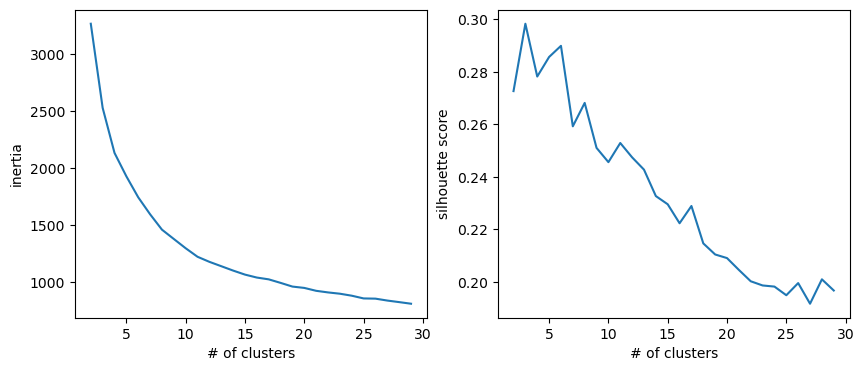

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(clusters, wcss)
axs[0].set_xlabel('# of clusters')
axs[0].set_ylabel('inertia')

axs[1].plot(clusters, silhouettes)
axs[1].set_xlabel('# of clusters')
axs[1].set_ylabel('silhouette score')

Text(0, 0.5, 'inertia curvature')

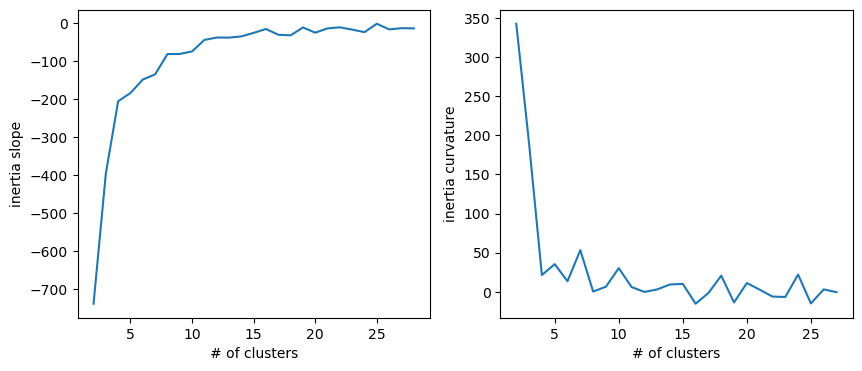

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(clusters[:-1], slope)
axs[0].set_xlabel('# of clusters')
axs[0].set_ylabel('inertia slope')

axs[1].plot(clusters[:-2], curve)
axs[1].set_xlabel('# of clusters')
axs[1].set_ylabel('inertia curvature')

In [16]:
random_state = 101

# Initialise the model
kmeans = KMeans(n_clusters = 5, 
                n_init = "auto",
                random_state = random_state)

# Fit the model to the data
kmeans.fit(scaled_df)

# Obtain the cluster output
clusters = kmeans.labels_

# Attach the cluster output to our original DataFrame
scaled_df["cluster"] = clusters

scaled_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.680455,0.2590,1.000000,0.763897,0.0,0.375000,0.696787,0.000060,0.987842,0.310660,0.515800,0
1,0.767322,0.3990,0.181818,0.771967,1.0,0.184043,0.217871,0.000002,0.108409,0.703553,0.584322,3
3,0.729059,0.0502,0.363636,0.682811,1.0,0.250532,0.882530,0.000041,0.391084,0.531980,0.499098,4
4,0.673216,0.1190,0.545455,0.655228,1.0,0.202128,0.919679,0.000348,0.105370,0.408122,0.565171,4
5,0.481903,0.1460,0.272727,0.692837,1.0,0.345213,0.934739,0.156345,0.108409,0.429442,0.667718,4
6,0.698035,0.2070,1.000000,0.752828,0.0,0.289894,0.966867,0.420305,0.113475,0.694416,0.437081,4
8,0.717684,0.5460,0.909091,0.791432,1.0,0.212766,0.399598,0.077157,0.155015,0.650761,0.794579,1
9,0.697001,0.8640,0.090909,0.848179,1.0,0.203191,0.643574,0.363452,0.140831,0.544162,0.467288,3
10,0.662875,0.1400,0.727273,0.704411,1.0,0.207447,0.870482,0.001685,0.106383,0.393909,0.604318,1
11,0.496381,0.4330,0.454545,0.816586,0.0,0.282979,0.610442,0.704569,0.109422,0.910660,0.384668,0


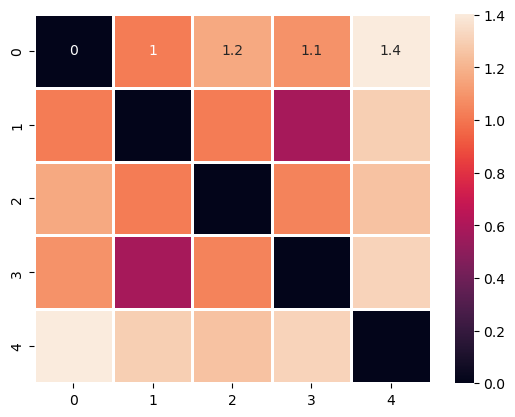

In [17]:
# Find the coordinates of each centroid using the cluster_centers_ attribute
centroids = kmeans.cluster_centers_

# Calculate the euclidean distance between the centroids
centroid_distances = pairwise_distances(centroids)

# Plot distances on heatmap
sns.heatmap(centroid_distances,
            annot=True,
            linewidths=1);

In [18]:
combined = pd.concat([df_general, scaled_df], axis=1)
combined.cluster.value_counts()
#combined#.loc[combined.cluster == 5]

cluster
0    1197
1    1063
3     928
2     777
4     774
Name: count, dtype: int64

In [19]:
scaled_df.groupby('cluster').agg(['mean'])#, 'std'])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,
0,0.630971,0.714529,0.555404,0.864040,0.000000,0.364685,0.200793,0.081667,0.195239,0.529499,0.562296
1,0.607004,0.693648,0.714787,0.859118,1.000000,0.331881,0.239673,0.030580,0.191539,0.569136,0.563317
2,0.287100,0.900142,0.454077,0.843263,0.746461,0.499785,0.009732,0.787192,0.208508,0.246043,0.572805
3,0.609732,0.691997,0.134698,0.855317,1.000000,0.323212,0.241087,0.035533,0.182410,0.581816,0.565573
4,0.343116,0.137737,0.464529,0.636664,0.665375,0.239340,0.932933,0.692745,0.144997,0.181623,0.491652


In [20]:
# turned off by default for better performance
#sns.pairplot(scaled_df, hue='cluster', palette='Set1')

# Define major clusters

From visual inspection of all parameter pairs, 4 parameters appear especially distinctive for cluster separation:

In [21]:
coarse_metrics = ['danceability', 'energy', 
           'acousticness', 'instrumentalness']

In [22]:
df_unused = combined.loc[:, ~combined.columns.isin(coarse_metrics)].copy()
df_unused = df_unused.drop(columns='cluster')
df_coarse = combined.loc[:, combined.columns.isin(coarse_metrics)].copy()
df_coarse.describe()

,danceability,energy,acousticness,instrumentalness
count,4739.000000,4739.000000,4739.000000,4739.000000
mean,0.518041,0.641661,0.305656,0.276655
std,0.222338,0.294926,0.366432,0.382850
min,0.000000,0.000000,0.000000,0.000000
25%,0.314374,0.451000,0.002344,0.000002
50%,0.546019,0.729000,0.102410,0.003574
75%,0.698035,0.890000,0.625000,0.713198
max,1.000000,1.000000,1.000000,1.000000


In [23]:
df_unused.head()

,name,artist,time_signature,id,key,loudness,mode,speechiness,liveness,valence,tempo
0,Se Eu Quiser Falar Com Deus,Gilberto Gil,4,1n7JnwviZ7zf0LR1tcGFq7,1.000000,0.763897,0.0,0.375000,0.987842,0.310660,0.515800
1,Saudade De Bahia,Antônio Carlos Jobim,4,5QGM1U0eCYrQuwSJwTm5Zq,0.181818,0.771967,1.0,0.184043,0.108409,0.703553,0.584322
3,Mulher Eu Sei,Chico César,4,3mXqOdlLE1k67WsAxryPFs,0.363636,0.682811,1.0,0.250532,0.391084,0.531980,0.499098
4,Rosa Morena,Kurt Elling,4,7bSzjzjTkWT2CkIPPdp0eA,0.545455,0.655228,1.0,0.202128,0.105370,0.408122,0.565171
5,Desafinado,Stan Getz,4,5pstSsK0G4q86gdyy1Spqh,0.272727,0.692837,1.0,0.345213,0.108409,0.429442,0.667718


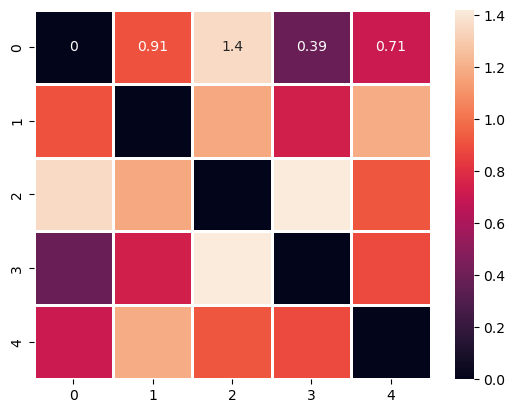

In [24]:
random_state = 101

# Initialise the model
kmeans = KMeans(n_clusters = 5, 
                n_init = "auto",
                random_state = random_state)

# Fit the model to the data
kmeans.fit(df_coarse)

# Obtain the cluster output
clusters = kmeans.labels_

# Attach the cluster output to our original DataFrame
df_coarse["cluster"] = clusters

# Find the coordinates of each centroid using the cluster_centers_ attribute
centroids = kmeans.cluster_centers_

# Calculate the euclidean distance between the centroids
centroid_distances = pairwise_distances(centroids)

# Plot distances on heatmap
sns.heatmap(centroid_distances,
            annot=True,
            linewidths=1);

In [25]:
#sns.pairplot(df_coarse, hue='cluster', palette='Set1')

In [26]:
df_coarse_combined = pd.concat([df_coarse, df_unused], axis=1)
df_coarse_combined.cluster.value_counts()

cluster
0    1715
1     834
4     812
3     772
2     606
Name: count, dtype: int64

In [27]:
df_coarse_combined.head()

,danceability,energy,acousticness,instrumentalness,cluster,name,artist,time_signature,id,key,loudness,mode,speechiness,liveness,valence,tempo
0,0.680455,0.2590,0.696787,0.000060,4,Se Eu Quiser Falar Com Deus,Gilberto Gil,4,1n7JnwviZ7zf0LR1tcGFq7,1.000000,0.763897,0.0,0.375000,0.987842,0.310660,0.515800
1,0.767322,0.3990,0.217871,0.000002,0,Saudade De Bahia,Antônio Carlos Jobim,4,5QGM1U0eCYrQuwSJwTm5Zq,0.181818,0.771967,1.0,0.184043,0.108409,0.703553,0.584322
3,0.729059,0.0502,0.882530,0.000041,4,Mulher Eu Sei,Chico César,4,3mXqOdlLE1k67WsAxryPFs,0.363636,0.682811,1.0,0.250532,0.391084,0.531980,0.499098
4,0.673216,0.1190,0.919679,0.000348,4,Rosa Morena,Kurt Elling,4,7bSzjzjTkWT2CkIPPdp0eA,0.545455,0.655228,1.0,0.202128,0.105370,0.408122,0.565171
5,0.481903,0.1460,0.934739,0.156345,4,Desafinado,Stan Getz,4,5pstSsK0G4q86gdyy1Spqh,0.272727,0.692837,1.0,0.345213,0.108409,0.429442,0.667718


In [28]:
df_coarse_combined['cluster'].value_counts()

cluster
0    1715
1     834
4     812
3     772
2     606
Name: count, dtype: int64

# Define minor clusters

In [29]:
fine_metrics = ['speechiness', 'liveness', 'valence', 'tempo']

In [30]:
df_fine_unused = df_coarse_combined.loc[:, ~df_coarse_combined.columns.isin(fine_metrics)].copy()
#df_fine_unused = df_fine_unused.drop(columns='cluster')
df_fine = df_coarse_combined.loc[:, df_coarse_combined.columns.isin(fine_metrics)].copy()
df_fine.describe()

,speechiness,liveness,valence,tempo
count,4739.000000,4739.000000,4739.000000,4739.000000
mean,0.350884,0.185867,0.445343,0.553352
std,0.199903,0.148582,0.282411,0.130724
min,0.000000,0.000000,0.000000,0.000000
25%,0.201596,0.093820,0.196954,0.452453
50%,0.274468,0.126646,0.408122,0.558250
75%,0.446543,0.236069,0.683249,0.623917
max,1.000000,1.000000,1.000000,1.000000


In [31]:
df_fine_unused.head()

,danceability,energy,acousticness,instrumentalness,cluster,name,artist,time_signature,id,key,loudness,mode
0,0.680455,0.2590,0.696787,0.000060,4,Se Eu Quiser Falar Com Deus,Gilberto Gil,4,1n7JnwviZ7zf0LR1tcGFq7,1.000000,0.763897,0.0
1,0.767322,0.3990,0.217871,0.000002,0,Saudade De Bahia,Antônio Carlos Jobim,4,5QGM1U0eCYrQuwSJwTm5Zq,0.181818,0.771967,1.0
3,0.729059,0.0502,0.882530,0.000041,4,Mulher Eu Sei,Chico César,4,3mXqOdlLE1k67WsAxryPFs,0.363636,0.682811,1.0
4,0.673216,0.1190,0.919679,0.000348,4,Rosa Morena,Kurt Elling,4,7bSzjzjTkWT2CkIPPdp0eA,0.545455,0.655228,1.0
5,0.481903,0.1460,0.934739,0.156345,4,Desafinado,Stan Getz,4,5pstSsK0G4q86gdyy1Spqh,0.272727,0.692837,1.0


In [32]:
cl = df_fine.loc[df_fine_unused.cluster == 0]
cl.head()

,speechiness,liveness,valence,tempo
1,0.184043,0.108409,0.703553,0.584322
8,0.212766,0.155015,0.650761,0.794579
12,0.350000,0.459980,0.828426,0.411365
14,0.165957,0.189463,0.929949,0.414253
32,0.225532,0.090881,0.483249,0.513206


In [33]:
wcss = []
clusters = []
silhouettes = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, 
                    #init='random',
                    init='k-means++',
                    n_init=10,
                    #n_init='auto',
                    max_iter=300,
                    random_state=101)
    kmeans.fit(cl)
    wcss.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(cl, kmeans.labels_))
    clusters.append(k)
    #print(kmeans.n_iter_)

#print(clusters, wcss)

In [34]:
slope = np.diff(wcss)
curve = np.diff(slope)
elbow = np.argmax(curve) + 1
print(clusters[elbow])

3


Text(0, 0.5, 'silhouette score')

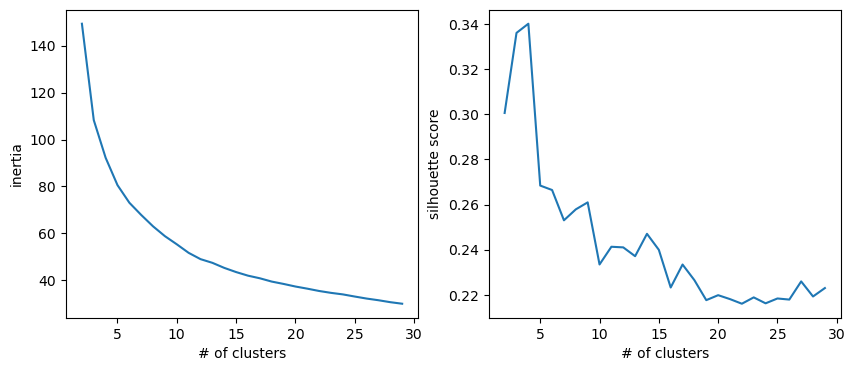

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(clusters, wcss)
axs[0].set_xlabel('# of clusters')
axs[0].set_ylabel('inertia')

axs[1].plot(clusters, silhouettes)
axs[1].set_xlabel('# of clusters')
axs[1].set_ylabel('silhouette score')

/tmp/ipykernel_3780/3067647916.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl["subcluster"] = clusters


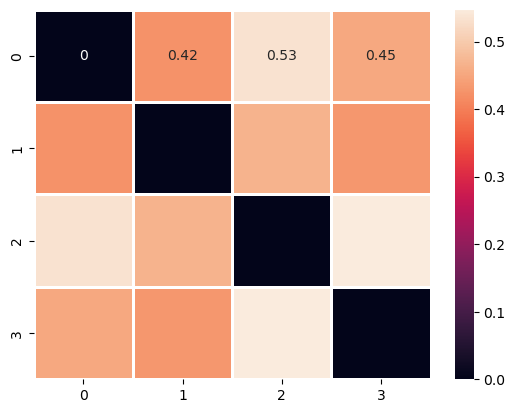

In [36]:
random_state = 101

# Initialise the model
kmeans = KMeans(n_clusters = 4, 
                n_init = "auto",
                random_state = random_state)

# Fit the model to the data
kmeans.fit(cl)

# Obtain the cluster output
clusters = kmeans.labels_

# Attach the cluster output to our original DataFrame
cl["subcluster"] = clusters

# Find the coordinates of each centroid using the cluster_centers_ attribute
centroids = kmeans.cluster_centers_

# Calculate the euclidean distance between the centroids
centroid_distances = pairwise_distances(centroids)

# Plot distances on heatmap
sns.heatmap(centroid_distances,
            annot=True,
            linewidths=1);

/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

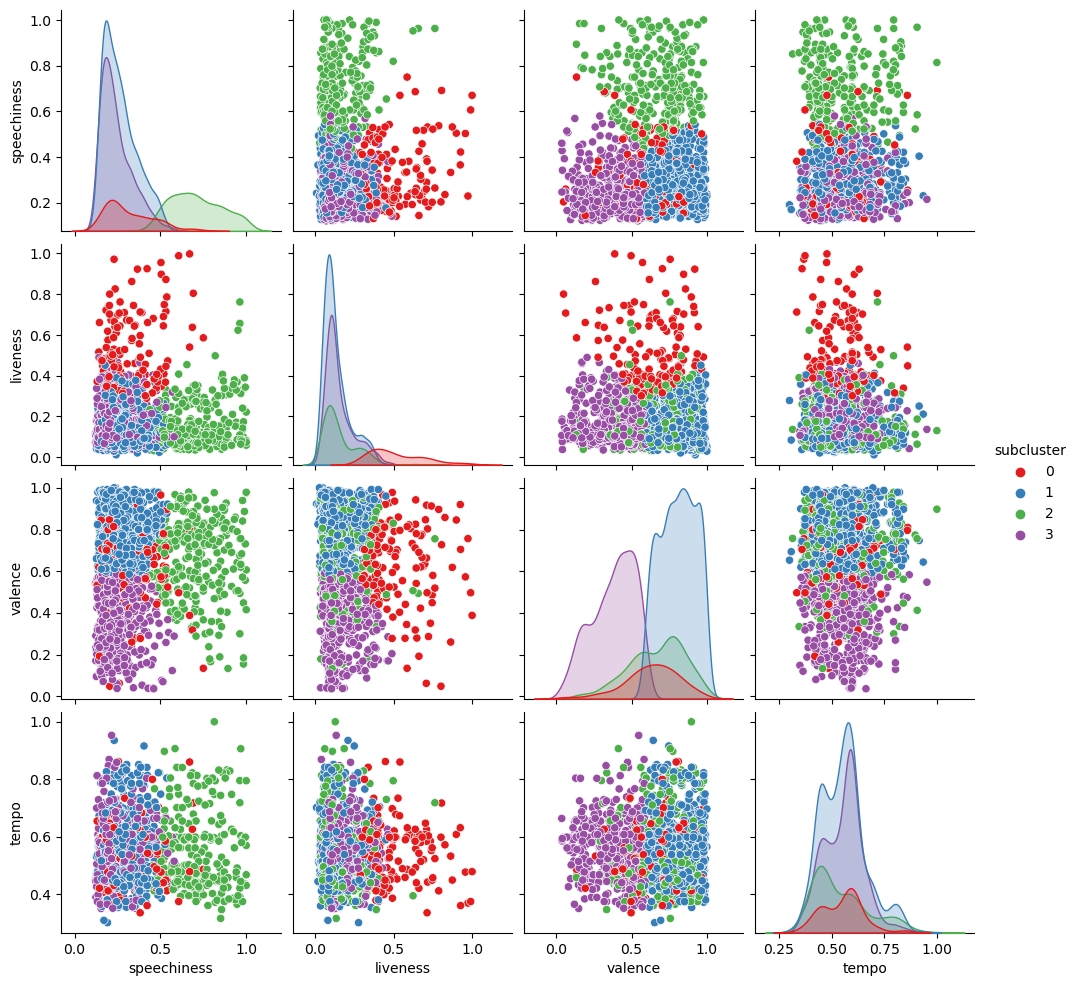

In [37]:
sns.pairplot(cl, hue='subcluster', palette='Set1')

# Push playlists to Spotify

In [38]:
import json 
import spotipy
import pickle
from spotipy.oauth2 import SpotifyOAuth

In [39]:
# specify path to spotify app login json with all correct info
login_file = '../../api_spotify.json'

scope = 'playlist-modify-public'
redirectUri = 'http://localhost:8080/' # as specified in the app settings

with open(login_file) as f:
    login = json.load(f)
    username = login['username']
    client_id = login['client_id']
    client_secret = login['client_secret']

print(client_id)

token = SpotifyOAuth(scope=scope,
                     username=username,
                     client_id=client_id,
                     client_secret=client_secret,
                     redirect_uri=redirectUri,
                     )

print(token)

spotifyObject = spotipy.Spotify(auth_manager = token)

cc55ee678d4d40c5b02f87f4bd880cae


In [40]:
playlist = df_fine_unused.loc[df_fine_unused['cluster'] == 0]
playlist_name = f'playlist_test'
playlist_description= 'this is a test list'
playlist.head()

,danceability,energy,acousticness,instrumentalness,cluster,name,artist,time_signature,id,key,loudness,mode
1,0.767322,0.399,0.217871,0.000002,0,Saudade De Bahia,Antônio Carlos Jobim,4,5QGM1U0eCYrQuwSJwTm5Zq,0.181818,0.771967,1.0
8,0.717684,0.546,0.399598,0.077157,0,Brigas Nunca Mais,Paula Morelenbaum,4,1wL2dk42Cxu4zCJs4SvFsZ,0.909091,0.791432,1.0
12,0.780765,0.732,0.488956,0.000924,0,Aqua De Coco,Marcos Valle,4,1OzHkIzGMj4S3rWwF8TBjc,0.909091,0.821623,0.0
14,0.639090,0.539,0.156627,0.002173,0,Mas Que Nada,Rio Combo,4,51P5Djwsur61UY4oitktOQ,0.454545,0.771266,0.0
32,0.762151,0.802,0.014659,0.351269,0,Parabens,Marcos Valle,4,596scNUBRpj2AygfaBVyTj,0.636364,0.846581,1.0


In [45]:
# specify path to spotify app login json with all correct info
login_file = '../../api_spotify.json'

with open(login_file) as f:
    login = json.load(f)
    username = login['username']
    client_id = login['client_id']
    client_secret = login['client_secret']

class SpotifyApi:
    def init(self):
        self.handler: spotipy.Spotify = self.get_handler()

    def token(self):
        return SpotifyOAuth(
            client_id=client_id,
            client_secret=client_secret,
            redirect_uri='http://localhost:8080/', # as specified in the app settings
            scope='playlist-modify-public',
            username=username,
        )

    def get_handler(self):
        return spotipy.Spotify(auth_manager=self.token())

In [50]:
spoti = SpotifyApi()
spoti

In [41]:
playlist_collection = {}
playlist_id = spotifyObject.user_playlist_create(user=username,
                                                name=playlist_name,
                                                public=True,
                                                description=playlist_description)['id']
id_list = list(playlist.sample(10) # Here, we simply take 5 songs randomly from each cluster
               .id)
# Spotify needs cetain text wrappers around ID numbers to identify the target as a track, a playlist, etc.
uris = [f'spotify:track:{str(id).strip()}' for id in id_list]
playlist_collection[playlist_name] = playlist_id

print(playlist_id)
print(id_list[0:6])
print(uris[0:6])
print(playlist_collection)

43VYq6gR4nDgloqXXh1X2h
['4Whe2TvDChfqpno4dn0s4B', '2qjUQp62E0HFH6i16YkPEC', '7rbtNjuh56l71xV7Uowf50', '2bjweVDsMtSvyDFpQ6JnBa', '4iI2N6gFBHWoV99d9q0clR', '0KURlSvVShmFDbw1oum9QS']
['spotify:track:4Whe2TvDChfqpno4dn0s4B', 'spotify:track:2qjUQp62E0HFH6i16YkPEC', 'spotify:track:7rbtNjuh56l71xV7Uowf50', 'spotify:track:2bjweVDsMtSvyDFpQ6JnBa', 'spotify:track:4iI2N6gFBHWoV99d9q0clR', 'spotify:track:0KURlSvVShmFDbw1oum9QS']
{'playlist_test': '43VYq6gR4nDgloqXXh1X2h'}


In [42]:
spotifyObject.user_playlist_add_tracks(user=username,
                                       playlist_id=playlist_id,
                                       tracks=[])#uris)
# When this code is run, either a browser window will open, or in Google Colab a URL will appear
# This URL will ask you to sign in to Spotify
# After signing in, copy the URL you are redirected to and paste it in the box that pops up

HTTP Error for POST to https://api.spotify.com/v1/playlists/43VYq6gR4nDgloqXXh1X2h/tracks with Params: {'position': None} returned 403 due to Insufficient client scope.


SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/playlists/43VYq6gR4nDgloqXXh1X2h/tracks:
 Insufficient client scope., reason: None

## Save playlist

In [43]:
# Playlist IDs can be saved for later
with open("./playlists.pkl", "wb") as f:
    pickle.dump(playlist_collection, f)

## Overwriting an existing playlist

In [44]:
with open("./playlists.pkl", "rb") as f:
    playlist_collection = pickle.load(f)
uris = [f'spotify:track:{str(id).strip()}' for id in playlist.sample(10).id]
playlist_id = playlist_collection[playlist_name] # We now replace the 5 songs in playlist 0 with 10 different songs

spotifyObject.user_playlist_replace_tracks(user=username, playlist_id=playlist_id, tracks=uris)

{'snapshot_id': 'MixiNzc3MGZkMjcxNTU1MmM0YzBjZjU1NWMzYzcwM2NmZTE4ZmZmNjVh'}